### Synopsis
This code plots the averaged SA-XPCS results for the temperature ramping (up and down).   
Need to run the analysis code to generate the `checkpoint.pickle` file prior to running the figure rendering code

In [1]:

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pickle
import matplotlib.ticker as ticker


Minimum chi-squared: Curve 1, q_scale=1.0500, i_scale=0.8900, chi2=0.0001


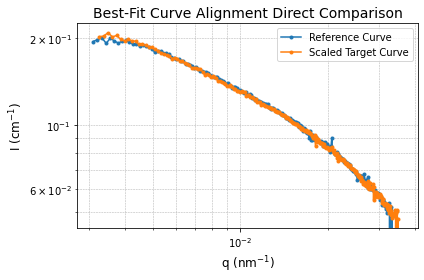

In [2]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

# Load the data
with open('checkpoint.pickle', 'rb') as f:
    avg_ramp_up = pickle.load(f)
    avg_ramp_down = pickle.load(f)
    t_el = pickle.load(f)
    ql_sta = pickle.load(f)
    ql_dyn = pickle.load(f)
    
# Define the chi-squared metric for direct comparison
def chi_squared_direct(q_scale, i_scale, ref_x, ref_y, target_x, target_y):
    """
    Calculate chi-squared directly comparing the reference curve with the scaled target curve.
    Formula: chi^2 = sum((O - E)^2 / E)
    """
    # Scale the target curve
    target_x = np.log10(target_x[:-20])
    target_y = np.log10(target_y[:-20])
    ref_x = np.log10(ref_x[:-20])
    ref_y= np.log10(ref_y[:-20])

    scaled_x = target_x + np.log10(q_scale)
    scaled_y = target_y + np.log10(i_scale)
       
    range_x_min = np.max([np.min(scaled_x), np.min(ref_x)])
    range_x_max = np.min([np.max(scaled_x), np.max(ref_x)])
    range_x_overlap = np.where((scaled_x > range_x_min) & (scaled_x < range_x_max))
    # range_ref_x = np.where((ref_x > range_x_min) & (ref_x < range_x_max))
    
    # for index,x in enumerate(scaled_x):
    #     if x > np.max(target_x):
    #         break
    #     min_num_index = np.argmin(np.abs(x-ref_x))
    
    ref_y_inter= np.interp(scaled_x[range_x_overlap],ref_x,ref_y)
    # chi2 = np.sum(((scaled_y - ref_y_inter)**2)
    # chi2 = chi2+((scaled_y[index]-ref_y[index])**2)
    chi2 = np.mean((scaled_y[range_x_overlap] - ref_y_inter)**2)
#         # Calculate chi-squared for y-alignment
#         chi2_y = np.sum(((ref_y - scaled_y) ** 2) / scaled_y)

    return chi2

# Iterate over a range of multipliers to compute chi-squared
def iterate_chi_squared_direct(avg_data_list, ql_sta):
    """
    Iterate over q_scale and i_scale multipliers and compute chi-squared values for direct comparison.
    """
    ref_x = ql_sta
    ref_y = avg_data_list[0]['saxs_1d']  # First curve is the reference

    chi2_results = []

    # Define the ranges for q_scale and i_scale
    q_scale_range = np.arange(0.5, 1.5, 0.01)  # Increment by 0.1
    i_scale_range = np.arange(0.5, 1.5, 0.01)  # Increment by 0.1

    # Use only the first two curves
    target_x = ql_sta
    target_y = avg_data_list[1]['saxs_1d']  # Second curve

    for q_scale in q_scale_range:
        for i_scale in i_scale_range:
            
            chi2 = chi_squared_direct(q_scale, i_scale, ref_x, ref_y, target_x, target_y)
            chi2_results.append((1, q_scale, i_scale, chi2))

    return chi2_results

# Run the chi-squared iteration and save results
chi2_results = iterate_chi_squared_direct(avg_ramp_up, ql_sta)
# plt.plot(chi2_results)

# Find the minimum chi-squared result
min_chi2_result = min(chi2_results, key=lambda x: x[3])

# Save results to a file
with open('chi2_results.txt', 'w') as f:
    for result in chi2_results:
        f.write(f"Curve {result[0]}: q_scale={result[1]:.4f}, i_scale={result[2]:.4f}, chi2={result[3]:.4f}\n")

# Print the minimum chi-squared result
print(f"Minimum chi-squared: Curve {min_chi2_result[0]}, q_scale={min_chi2_result[1]:.4f}, i_scale={min_chi2_result[2]:.4f}, chi2={min_chi2_result[3]:.4f}")


# Plot the first two curves with the best-fit multipliers
fig, ax = plt.subplots(figsize=(6, 4))

# Reference curve (first curve)
ref_x = ql_sta
ref_y = avg_ramp_up[0]['saxs_1d']
ax.loglog(ref_x, ref_y, label='Reference Curve', marker='o', linestyle='-', markersize=3)

# Target curve (second curve), scaled with the best-fit multipliers
target_x = ql_sta
target_y = avg_ramp_up[1]['saxs_1d']
best_q_scale = min_chi2_result[1]
best_i_scale = min_chi2_result[2]
scaled_x = target_x * best_q_scale
scaled_y = target_y * best_i_scale
ax.loglog(scaled_x, scaled_y, label='Scaled Target Curve', marker='o', linestyle='-', markersize=3)

# Add plot labels and legend
ax.set_xlabel('q ($\mathdefault{nm^{-1}}$)', fontsize=12)
ax.set_ylabel('I (cm$^\mathdefault{-1}$)', fontsize=12)
ax.set_title('Best-Fit Curve Alignment Direct Comparison', fontsize=14)
ax.legend()
ax.grid(which='both', linestyle='--', linewidth=0.5)

# Save and show the plot
plt.tight_layout()
plt.savefig('best_fit_alignment_direct_plot.pdf')
plt.show()
# print(ref_y)
# print(ql_sta[:10])
# print(1.2*ql_sta[:10])

Curve 1: q_scale=1.0500, i_scale=0.8940, chi2=0.0001
Curve 2: q_scale=1.1000, i_scale=0.7810, chi2=0.0001
Curve 3: q_scale=1.2200, i_scale=0.6510, chi2=0.0001
Curve 4: q_scale=1.4200, i_scale=0.5080, chi2=0.0001
Curve 5: q_scale=1.9700, i_scale=0.2980, chi2=0.0001
Curve 6: q_scale=3.4600, i_scale=0.1040, chi2=0.0000
Curve 7: q_scale=6.1300, i_scale=0.0170, chi2=0.0001
Curve 8: q_scale=10.1800, i_scale=0.0020, chi2=0.0004


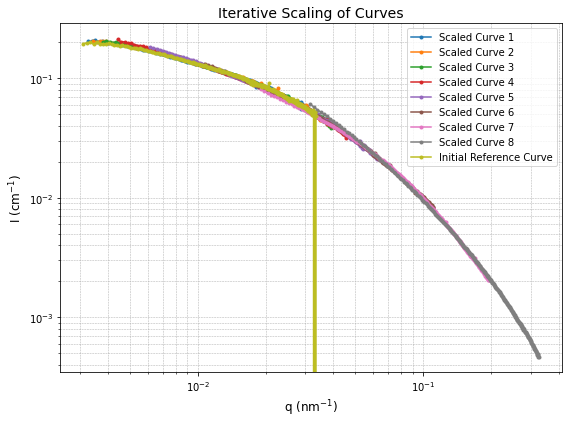

In [48]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

# Load the data
with open('checkpoint.pickle', 'rb') as f:
    avg_ramp_up = pickle.load(f)
    avg_ramp_down = pickle.load(f)
    t_el = pickle.load(f)
    ql_sta = pickle.load(f)
    ql_dyn = pickle.load(f)
    
# Define the chi-squared metric for direct comparison
def chi_squared_direct(q_scale, i_scale, ref_x, ref_y, target_x, target_y):
    """
    Calculate chi-squared directly comparing the reference curve with the scaled target curve.
    Formula: chi^2 = sum((O - E)^2 / E)
    """
    # Scale the target curve
    target_x = np.log10(target_x)
    target_y = np.log10(target_y)
    ref_x = np.log10(ref_x)
    ref_y= np.log10(ref_y)

    scaled_x = target_x + np.log10(q_scale)
    scaled_y = target_y + np.log10(i_scale)
       
    range_x_min = np.max([np.min(scaled_x), np.min(ref_x)])
    range_x_max = np.min([np.max(scaled_x), np.max(ref_x)])
    range_x_overlap = np.where((scaled_x > range_x_min) & (scaled_x < range_x_max))

    ref_y_inter= np.interp(scaled_x[range_x_overlap],ref_x,ref_y)

    chi2 = np.mean((scaled_y[range_x_overlap] - ref_y_inter)**2)

    return chi2

def iterative_scaling(avg_data_list, ql_sta):
    """
    Iteratively scale each curve in the dataset, using the previously scaled curve as the reference.
    Dynamically adjust the q_scale range based on the curve index.
    """
    # Initialize reference curve with the first curve in the dataset
    ref_x = ql_sta[:-30]
    ref_y = avg_data_list[0]['saxs_1d'][:-30]

    # Store results for each curve
    scaling_results = []
    scaled_curves = []

    for i in range(1, len(avg_data_list)):  # Start from the second curve
        target_x = ql_sta[:-20]
        target_y = avg_data_list[i]['saxs_1d'][:-20]
        i_scale_range = np.arange(0.001, 1.5, 0.001)
        # Set dynamic q_scale range based on the curve index
        if i <= 4:  # Curves 1–4
            q_scale_range = np.arange(0.5, 2.0, 0.01)
        elif i <= 6:  # Curves 5–6
            q_scale_range = np.arange(1.9, 4.2, 0.01)
        elif i == 7:  # Curve 7
            q_scale_range = np.arange(5.5, 7.0, 0.01)
        elif i == 8:  # Curve 8
            q_scale_range = np.arange(9.5, 11.0, 0.01)
        # elif i == 9:  # Curve 9 (last curve)
        #     q_scale_range = np.arange(12.15,13, 0.01)
        #     i_scale_range = np.arange(7e-4, 1e-3, 0.001)
        #     # q_scale_range = [12.15]
        #     # i_scale_range = [8e-4]
        #     break
        else:
            raise ValueError(f"Unexpected curve index: {i}")

        # Keep i_scale range static
        

        # Iterate over scaling factors
        chi2_results = []

        for q_scale in q_scale_range:
            for i_scale in i_scale_range:
                chi2 = chi_squared_direct(q_scale, i_scale, ref_x, ref_y, target_x, target_y)
                chi2_results.append((q_scale, i_scale, chi2))

        # Find the best scaling factors
        best_q_scale, best_i_scale, min_chi2 = min(chi2_results, key=lambda x: x[2])
        scaling_results.append((i, best_q_scale, best_i_scale, min_chi2))

        # Apply the best scaling to the current curve
        scaled_x = target_x * best_q_scale
        scaled_y = target_y * best_i_scale
        scaled_curves.append((scaled_x, scaled_y))

        # Update reference curve for the next iteration
        ref_x = scaled_x
        ref_y = scaled_y

    return scaling_results, scaled_curves


# Apply the iterative scaling method
scaling_results, scaled_curves = iterative_scaling(avg_ramp_up[0:-1], ql_sta)

# Save the scaling results to a file
with open('iterative_scaling_results.txt', 'w') as f:
    for result in scaling_results:
        f.write(f"Curve {result[0]}: q_scale={result[1]:.4f}, i_scale={result[2]:.4f}, chi2={result[3]:.4f}\n")

# Print the results
for result in scaling_results:
    print(f"Curve {result[0]}: q_scale={result[1]:.4f}, i_scale={result[2]:.4f}, chi2={result[3]:.4f}")

# Plot all the scaled curves
fig, ax = plt.subplots(figsize=(8, 6))
for i, (scaled_x, scaled_y) in enumerate(scaled_curves):
    ax.loglog(scaled_x, scaled_y, label=f'Scaled Curve {i+1}', marker='o', linestyle='-', markersize=3)

# Plot the initial reference curve
ref_x = ql_sta
ref_y = avg_ramp_up[0]['saxs_1d']
ax.loglog(ref_x, ref_y, label='Initial Reference Curve', marker='o', linestyle='-', markersize=3)

# Add labels, legend, and grid
ax.set_xlabel('q ($\mathdefault{nm^{-1}}$)', fontsize=12)
ax.set_ylabel('I (cm$^\mathdefault{-1}$)', fontsize=12)
ax.set_title('Iterative Scaling of Curves', fontsize=14)
ax.legend()
ax.grid(which='both', linestyle='--', linewidth=0.5)

# Save and show the plot
plt.tight_layout()
plt.savefig('iterative_scaling_plot.pdf')
plt.show()

Curve 1: q_scale=1.0600, i_scale=0.8870, chi2=0.0001
Curve 2: q_scale=1.1300, i_scale=0.7650, chi2=0.0001
Curve 3: q_scale=1.2600, i_scale=0.6340, chi2=0.0001
Curve 4: q_scale=1.4500, i_scale=0.5000, chi2=0.0001
Curve 5: q_scale=1.9800, i_scale=0.2970, chi2=0.0001
Curve 6: q_scale=3.4300, i_scale=0.1050, chi2=0.0000
Curve 7: q_scale=6.1300, i_scale=0.0170, chi2=0.0002
Curve 8: q_scale=10.1800, i_scale=0.0020, chi2=0.0004


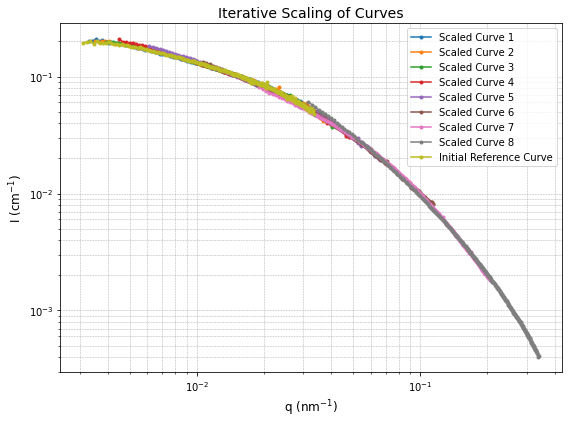

In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

# Load the data
with open('checkpoint.pickle', 'rb') as f:
    avg_ramp_up = pickle.load(f)
    avg_ramp_down = pickle.load(f)
    t_el = pickle.load(f)
    ql_sta = pickle.load(f)
    ql_dyn = pickle.load(f)

# Function to preprocess data and remove non-positive values
def preprocess_data(avg_data_list, ql_sta):
    """
    Preprocess the data to remove non-positive values from q and I.
    Returns cleaned q and avg_data_list.
    """
    cleaned_data_list = []
    cleaned_ql_sta = []

    for curve in avg_data_list[0:-1]:
        q = ql_sta
        i = curve['saxs_1d']
        
        # Filter to ensure both q and I are positive
        valid_indices = (q > 0) & (i > 0)
        cleaned_q = q[valid_indices]
        cleaned_i = i[valid_indices]

        if len(cleaned_q) > 0 and len(cleaned_i) > 0:
            cleaned_ql_sta.append(cleaned_q)
            cleaned_data_list.append({'saxs_1d': cleaned_i})

    return cleaned_data_list, cleaned_ql_sta

# Preprocess the data
avg_ramp_up_cleaned, ql_sta_cleaned = preprocess_data(avg_ramp_up, ql_sta)

# Define the chi-squared metric for direct comparison
def chi_squared_direct(q_scale, i_scale, ref_x, ref_y, target_x, target_y):
    """
    Calculate chi-squared directly comparing the reference curve with the scaled target curve.
    Formula: chi^2 = sum((O - E)^2 / E)
    """
    target_x = np.log10(target_x)
    target_y = np.log10(target_y)
    ref_x = np.log10(ref_x)
    ref_y = np.log10(ref_y)

    scaled_x = target_x + np.log10(q_scale)
    scaled_y = target_y + np.log10(i_scale)

    range_x_min = np.max([np.min(scaled_x), np.min(ref_x)])
    range_x_max = np.min([np.max(scaled_x), np.max(ref_x)])
    range_x_overlap = np.where((scaled_x > range_x_min) & (scaled_x < range_x_max))

    ref_y_inter = np.interp(scaled_x[range_x_overlap], ref_x, ref_y)

    chi2 = np.mean((scaled_y[range_x_overlap] - ref_y_inter) ** 2)

    return chi2

# Iteratively scale curves
def iterative_scaling(avg_data_list, ql_sta_cleaned):
    """
    Iteratively scale each curve in the dataset, using the previously scaled curve as the reference.
    Dynamically adjust the q_scale range based on the curve index.
    """
    ref_x = ql_sta_cleaned[0]
    ref_y = avg_data_list[0]['saxs_1d']

    scaling_results = []
    scaled_curves = []

    for i in range(1, len(avg_data_list)):  # Start from the second curve
        target_x = ql_sta_cleaned[i]
        target_y = avg_data_list[i]['saxs_1d']

        # Set dynamic q_scale range based on curve index
        if i <= 4:  # Curves 1–4
            q_scale_range = np.arange(0.5, 2.0, 0.01)
        elif i <= 6:  # Curves 5–6
            q_scale_range = np.arange(1.9, 4.2, 0.01)
        elif i == 7:  # Curve 7
            q_scale_range = np.arange(5.5, 7.0, 0.01)
        elif i == 8:  # Curve 8
            q_scale_range = np.arange(9.5, 11.0, 0.01)
        else:
            raise ValueError(f"Unexpected curve index: {i}")

        i_scale_range = np.arange(0.001, 1.5, 0.001)

        chi2_results = []
        for q_scale in q_scale_range:
            for i_scale in i_scale_range:
                chi2 = chi_squared_direct(q_scale, i_scale, ref_x, ref_y, target_x, target_y)
                chi2_results.append((q_scale, i_scale, chi2))

        best_q_scale, best_i_scale, min_chi2 = min(chi2_results, key=lambda x: x[2])
        scaling_results.append((i, best_q_scale, best_i_scale, min_chi2))

        scaled_x = target_x * best_q_scale
        scaled_y = target_y * best_i_scale
        scaled_curves.append((scaled_x, scaled_y))

        ref_x = scaled_x
        ref_y = scaled_y

    return scaling_results, scaled_curves

# Apply the iterative scaling method
scaling_results, scaled_curves = iterative_scaling(avg_ramp_up_cleaned, ql_sta_cleaned)

# Save the scaling results to a file
with open('iterative_scaling_results.txt', 'w') as f:
    for result in scaling_results:
        f.write(f"Curve {result[0]}: q_scale={result[1]:.4f}, i_scale={result[2]:.4f}, chi2={result[3]:.4f}\n")

# Print the results
for result in scaling_results:
    print(f"Curve {result[0]}: q_scale={result[1]:.4f}, i_scale={result[2]:.4f}, chi2={result[3]:.4f}")

# Plot all the scaled curves
fig, ax = plt.subplots(figsize=(8, 6))
for i, (scaled_x, scaled_y) in enumerate(scaled_curves):
    ax.loglog(scaled_x, scaled_y, label=f'Scaled Curve {i+1}', marker='o', linestyle='-', markersize=3)

# Plot the initial reference curve
ref_x = ql_sta_cleaned[0]
ref_y = avg_ramp_up_cleaned[0]['saxs_1d']
ax.loglog(ref_x, ref_y, label='Initial Reference Curve', marker='o', linestyle='-', markersize=3)

# Add labels, legend, and grid
ax.set_xlabel('q ($\mathdefault{nm^{-1}}$)', fontsize=12)
ax.set_ylabel('I (cm$^\mathdefault{-1}$)', fontsize=12)
ax.set_title('Iterative Scaling of Curves', fontsize=14)
ax.legend()
ax.grid(which='both', linestyle='--', linewidth=0.5)

# Save and show the plot
plt.tight_layout()
plt.savefig('iterative_scaling_plot.pdf')
plt.show()



Combined X Range: 0.0032859432542575564 to 0.339446044542317
Combined Y Range: 0.0004040510228305641 to 0.2082751779679378
Transformed Y Range: -23.025850847200086 to 6.243132420546758
Log X Range: -5.718101528457876 to -1.0804402708511514
Linear Fit Parameters: slope (b) = 1.7815, log(c) = 7.3113, c = 1.4971e+03


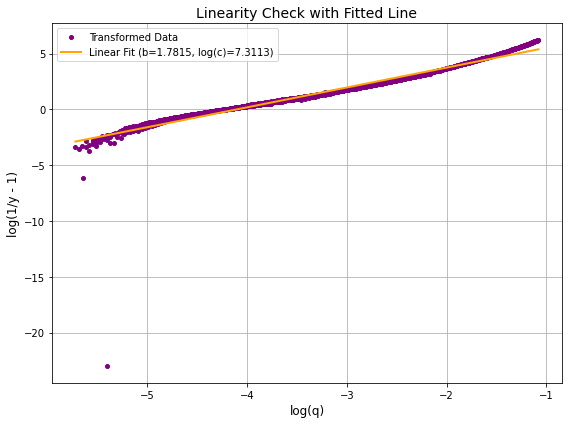

Fitted parameter: a = 8.8258, with fixed b = 1.7815 and c = 1.4971e+03
Fitted Y Range: 0.0001333551926314088 to 0.4879895162994207


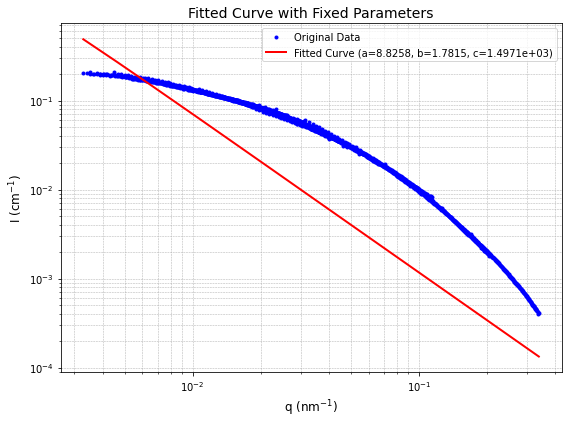

In [60]:
# Debug: Check data ranges
print(f"Combined X Range: {combined_x.min()} to {combined_x.max()}")
print(f"Combined Y Range: {combined_y.min()} to {combined_y.max()}")

# Normalize y for better numerical stability
normalized_y = combined_y / np.max(combined_y)

# Add a small epsilon to avoid infinities in the transformation
epsilon = 1e-10
normalized_y = np.clip(normalized_y, epsilon, 1 - epsilon)

# Calculate log(1/y - 1) and log(x)
transformed_y = np.log(1 / normalized_y - 1)
log_x = np.log(combined_x)

# Debug: Check transformed data
print(f"Transformed Y Range: {transformed_y.min()} to {transformed_y.max()}")
print(f"Log X Range: {log_x.min()} to {log_x.max()}")

# Fit a linear model to log(1/y - 1) vs log(x)
def linear_model(x, m, c):
    return m * x + c

popt, pcov = curve_fit(linear_model, log_x, transformed_y)
b_fixed, log_c_fixed = popt  # Slope and intercept
c_fixed = np.exp(log_c_fixed)  # Convert log(c) to c
print(f"Linear Fit Parameters: slope (b) = {b_fixed:.4f}, log(c) = {log_c_fixed:.4f}, c = {c_fixed:.4e}")

# Generate the fitted line
fitted_line = linear_model(log_x, b_fixed, log_c_fixed)

# Plot the linearity check with fitted line
plt.figure(figsize=(8, 6))
plt.plot(log_x, transformed_y, 'o', label='Transformed Data', color='purple', markersize=4)
plt.plot(log_x, fitted_line, label=f'Linear Fit (b={b_fixed:.4f}, log(c)={log_c_fixed:.4f})', color='orange', linewidth=2)
plt.xlabel('log(q)', fontsize=12)
plt.ylabel('log(1/y - 1)', fontsize=12)
plt.title('Linearity Check with Fitted Line', fontsize=14)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Fit for parameter a with fixed b and c
def fit_function_fixed(x, a):
    return fit_function(x, a, b_fixed, c_fixed)

popt, pcov = curve_fit(fit_function_fixed, combined_x, combined_y, p0=[1], bounds=([0], [np.inf]))
a_fit = popt[0]
print(f"Fitted parameter: a = {a_fit:.4f}, with fixed b = {b_fixed:.4f} and c = {c_fixed:.4e}")

# Generate the fitted curve
extended_x = np.linspace(combined_x.min(), combined_x.max(), 500)
fitted_y = fit_function(extended_x, a_fit, b_fixed, c_fixed)

# Debug: Check fitted curve ranges
print(f"Fitted Y Range: {fitted_y.min()} to {fitted_y.max()}")

# Plot the original data and the fitted curve
plt.figure(figsize=(8, 6))
plt.loglog(combined_x, combined_y, 'o', label='Original Data', color='blue', markersize=3)
plt.loglog(extended_x, fitted_y, label=f'Fitted Curve (a={a_fit:.4f}, b={b_fixed:.4f}, c={c_fixed:.4e})', color='red', linewidth=2)

# Add labels, legend, and grid
plt.xlabel('q ($\mathdefault{nm^{-1}}$)', fontsize=12)
plt.ylabel('I (cm$^\mathdefault{-1}$)', fontsize=12)
plt.title('Fitted Curve with Fixed Parameters', fontsize=14)
plt.legend()
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


Curve 1: Fitted Iq0 = 0.1949, Fitted x = 59.2742
Curve 2: Fitted Iq0 = 0.2198, Fitted x = 62.6895
Curve 3: Fitted Iq0 = 0.2540, Fitted x = 66.2649
Curve 4: Fitted Iq0 = 0.3035, Fitted x = 72.8190
Curve 5: Fitted Iq0 = 0.3883, Fitted x = 84.1585
Curve 6: Fitted Iq0 = 0.6189, Fitted x = 107.2572
Curve 7: Fitted Iq0 = 1.5260, Fitted x = 161.8022
Curve 8: Fitted Iq0 = 7.3338, Fitted x = 238.0908
Curve 9: Fitted Iq0 = 160.6682, Fitted x = 721.2847


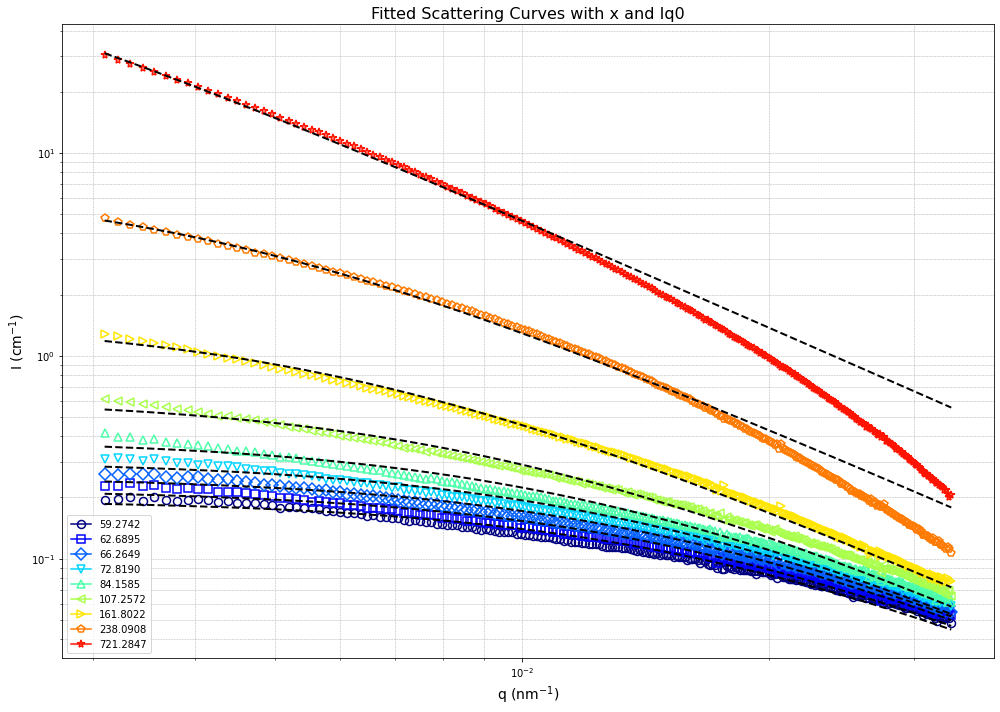

In [16]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from matplotlib.lines import Line2D

# Load the data
with open('checkpoint.pickle', 'rb') as f:
    avg_ramp_up = pickle.load(f)
    avg_ramp_down = pickle.load(f)
    t_el = pickle.load(f)
    ql_sta = pickle.load(f)
    ql_dyn = pickle.load(f)

# Function to preprocess data and remove non-positive values
def preprocess_data(avg_data_list, ql_sta):
    cleaned_data_list = []
    cleaned_ql_sta = []

    for curve in avg_data_list[:-1]:  # Exclude the last curve
        q = ql_sta
        i = curve['saxs_1d']
        
        valid_indices = (q > 0) & (i > 0)
        cleaned_q = q[valid_indices]
        cleaned_i = i[valid_indices]

        if len(cleaned_q) > 0 and len(cleaned_i) > 0:
            cleaned_ql_sta.append(cleaned_q)
            cleaned_data_list.append({'saxs_1d': cleaned_i})

    return cleaned_data_list, cleaned_ql_sta

# Preprocess the data
avg_ramp_up_cleaned, ql_sta_cleaned = preprocess_data(avg_ramp_up, ql_sta)

# Define the fitting function
def scattering_fit(q, Iq0, x):
    b = 1.7815  # Fixed value
    return Iq0 / (1 + (x * q)**b)

# Fit each temperature curve
fitted_parameters = []
fitted_curves = []

for i, (q, data) in enumerate(zip(ql_sta_cleaned, avg_ramp_up_cleaned)):
    I = data['saxs_1d']

    # Fit the curve
    try:
        popt, pcov = curve_fit(scattering_fit, q, I, p0=[np.max(I), 1], bounds=([0, 0], [np.inf, np.inf]))
        Iq0_fit, x_fit = popt
        fitted_parameters.append((Iq0_fit, x_fit))

        # Generate the fitted curve
        fitted_I = scattering_fit(q, Iq0_fit, x_fit)
        fitted_curves.append((q, fitted_I))

        print(f"Curve {i+1}: Fitted Iq0 = {Iq0_fit:.4f}, Fitted x = {x_fit:.4f}")

    except RuntimeError as e:
        print(f"Curve {i+1}: Fitting failed - {str(e)}")

# Generate a colormap based on the number of curves
cmap = plt.get_cmap('jet')
total_curves = len(ql_sta_cleaned)
colors = [cmap(i / total_curves) for i in range(total_curves)]

# Define marker styles for the original curves
marker_styles = ['o', 's', 'D', 'v', '^', '<', '>', 'p', '*']  # Variety of marker types

# Plot all the original and fitted curves
fig, ax = plt.subplots(figsize=(14, 10))  # Larger figure size

for i, (q, data) in enumerate(zip(ql_sta_cleaned, avg_ramp_up_cleaned)):
    color = colors[i]  # Use colormap-based color
    marker = marker_styles[i % len(marker_styles)]  # Cycle through marker styles
    ax.loglog(
        q, 
        data['saxs_1d'], 
        marker, 
        label=f'{fitted_parameters[i][1]:.4f}', 
        color=color, 
        markersize=8, 
        markerfacecolor='none',  # Make the marker hollow
        markeredgewidth=1.5  # Thicker edge for visibility
    )

for i, (q, fitted_I) in enumerate(fitted_curves):
    ax.loglog(q, fitted_I, '--', color='black', linewidth=2)  # Always use red for the fitted line

# Add a legend with markers and x values
legend_elements = [
    Line2D(
        [0], [0], 
        marker=marker_styles[i % len(marker_styles)], 
        color=colors[i], 
        label=f'{fitted_parameters[i][1]:.4f}', 
        markersize=8, 
        markerfacecolor='none', 
        markeredgewidth=1.5
    )
    for i in range(len(fitted_parameters))
]

ax.legend(handles=legend_elements, loc='lower left', fontsize=10, frameon=True)

# Add labels, title, and grid
ax.set_xlabel('q ($\mathdefault{nm^{-1}}$)', fontsize=14)
ax.set_ylabel('I (cm$^\mathdefault{-1}$)', fontsize=14)
ax.set_title('Fitted Scattering Curves with x and Iq0', fontsize=16)
ax.grid(which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()



Curve 1: Fitted Iq0 = 0.1949, Fitted x = 59.2742
Curve 2: Fitted Iq0 = 0.2198, Fitted x = 62.6895
Curve 3: Fitted Iq0 = 0.2540, Fitted x = 66.2649
Curve 4: Fitted Iq0 = 0.3035, Fitted x = 72.8190
Curve 5: Fitted Iq0 = 0.3883, Fitted x = 84.1585
Curve 6: Fitted Iq0 = 0.6189, Fitted x = 107.2572
Curve 7: Fitted Iq0 = 1.5260, Fitted x = 161.8022
Curve 8: Fitted Iq0 = 7.3338, Fitted x = 238.0908
Curve 9: Fitted Iq0 = 160.6682, Fitted x = 721.2847


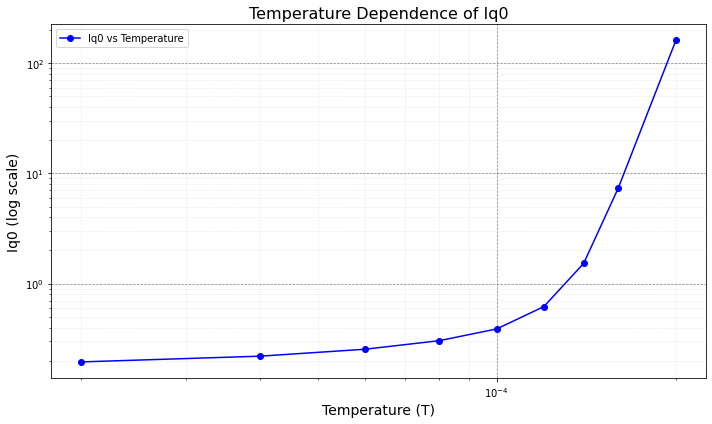

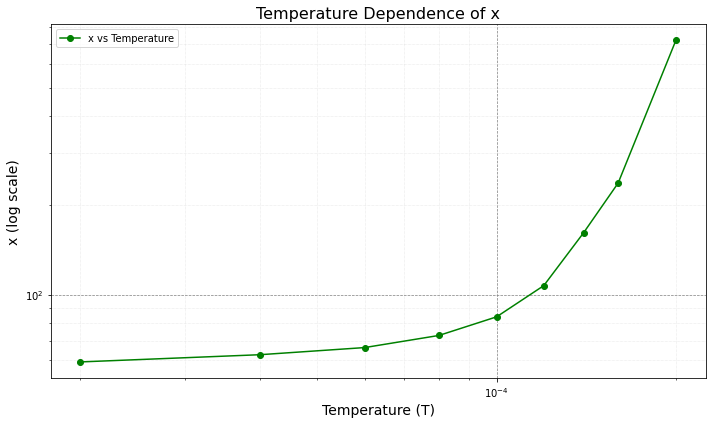

In [36]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from matplotlib.ticker import LogLocator

# Load the data
with open('checkpoint.pickle', 'rb') as f:
    avg_ramp_up = pickle.load(f)
    avg_ramp_down = pickle.load(f)
    t_el = pickle.load(f)
    ql_sta = pickle.load(f)
    ql_dyn = pickle.load(f)

# Function to preprocess data and remove non-positive values
def preprocess_data(avg_data_list, ql_sta):
    cleaned_data_list = []
    cleaned_ql_sta = []

    for curve in avg_data_list[:-1]:  # Exclude the last curve
        q = ql_sta
        i = curve['saxs_1d']
        
        valid_indices = (q > 0) & (i > 0)
        cleaned_q = q[valid_indices]
        cleaned_i = i[valid_indices]

        if len(cleaned_q) > 0 and len(cleaned_i) > 0:
            cleaned_ql_sta.append(cleaned_q)
            cleaned_data_list.append({'saxs_1d': cleaned_i})

    return cleaned_data_list, cleaned_ql_sta

# Preprocess the data
avg_ramp_up_cleaned, ql_sta_cleaned = preprocess_data(avg_ramp_up, ql_sta)

# Define the fitting function
def scattering_fit(q, Iq0, x):
    b = 1.7815  # Fixed value
    return Iq0 / (1 + (x * q)**b)

# Fit each temperature curve
fitted_parameters = []
fitted_curves = []

for i, (q, data) in enumerate(zip(ql_sta_cleaned, avg_ramp_up_cleaned)):
    I = data['saxs_1d']

    # Fit the curve
    try:
        popt, pcov = curve_fit(scattering_fit, q, I, p0=[np.max(I), 1], bounds=([0, 0], [np.inf, np.inf]))
        Iq0_fit, x_fit = popt
        fitted_parameters.append((Iq0_fit, x_fit))

        # Generate the fitted curve
        fitted_I = scattering_fit(q, Iq0_fit, x_fit)
        fitted_curves.append((q, fitted_I))

        print(f"Curve {i+1}: Fitted Iq0 = {Iq0_fit:.4f}, Fitted x = {x_fit:.4f}")

    except RuntimeError as e:
        print(f"Curve {i+1}: Fitting failed - {str(e)}")

# Plot the temperature dependence of Iq0
fig, ax = plt.subplots(figsize=(10, 6))
temperatures = t_el[:len(fitted_parameters)]  # Adjust temperature array length
Iq0_values = [param[0] for param in fitted_parameters]

ax.semilogy(temperatures, Iq0_values, 'o-', color='blue', label='Iq0 vs Temperature')

# Set X-axis to log scale and specify tick positions
ax.set_xscale('log')
ax.xaxis.set_major_locator(LogLocator(base=10.0, numticks=10))  # Logarithmic major ticks
ax.xaxis.set_minor_locator(LogLocator(base=10.0, subs=np.arange(1.0, 10.0) * 0.1, numticks=10))  # Logarithmic minor ticks
ax.minorticks_on()
# Enable grid for both major and minor ticks
ax.grid(which='major', linestyle='--', linewidth=0.7, color='gray')  # Grid for major ticks
ax.grid(which='minor', linestyle=':', linewidth=0.5, color='lightgray')  # Grid for minor ticks

# Add labels, title, and legend
ax.set_xlabel('Temperature (T)', fontsize=14)
ax.set_ylabel('Iq0 (log scale)', fontsize=14)
ax.set_title('Temperature Dependence of Iq0', fontsize=16)
ax.legend()

plt.tight_layout()
plt.show()

# Plot the temperature dependence of x
fig, ax = plt.subplots(figsize=(10, 6))
x_values = [param[1] for param in fitted_parameters]

ax.semilogy(temperatures, x_values, 'o-', color='green', label='x vs Temperature')

# Set X-axis to log scale and specify tick positions
ax.set_xscale('log')
ax.xaxis.set_major_locator(LogLocator(base=10.0, numticks=10))  # Logarithmic major ticks
ax.xaxis.set_minor_locator(LogLocator(base=10.0, subs=np.arange(1.0, 10.0) * 0.1, numticks=10))  # Logarithmic minor ticks

# Enable grid for both major and minor ticks
ax.grid(which='major', linestyle='--', linewidth=0.7, color='gray')  # Grid for major ticks
ax.grid(which='minor', linestyle=':', linewidth=0.5, color='lightgray')  # Grid for minor ticks
ax.minorticks_on()
# Add labels, title, and legend
ax.set_xlabel('Temperature (T)', fontsize=14)
ax.set_ylabel('x (log scale)', fontsize=14)
ax.set_title('Temperature Dependence of x', fontsize=16)
ax.legend()

plt.tight_layout()
plt.show()



Temperatures for cleaned curves: [1.9999999494757503e-05, 3.9999998989515007e-05, 5.999999848427251e-05, 7.999999797903001e-05, 9.999999747378752e-05, 0.00011999999696854502, 0.00013999999646330252, 0.00015999999595806003, 0.00019999999494757503]


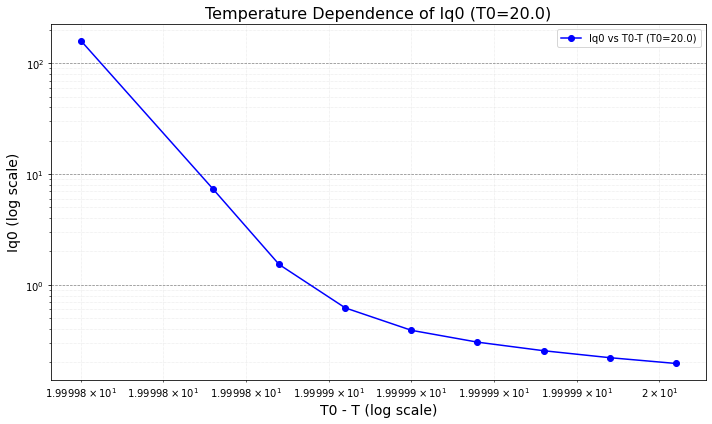

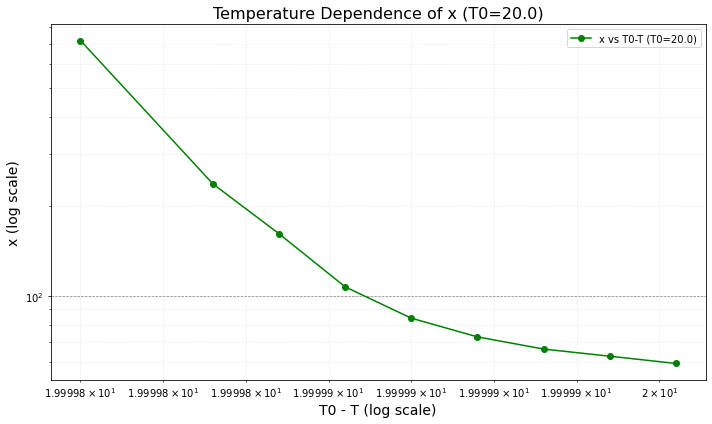

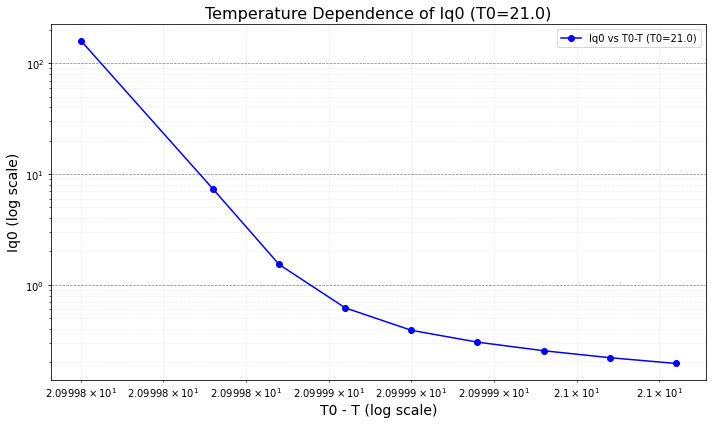

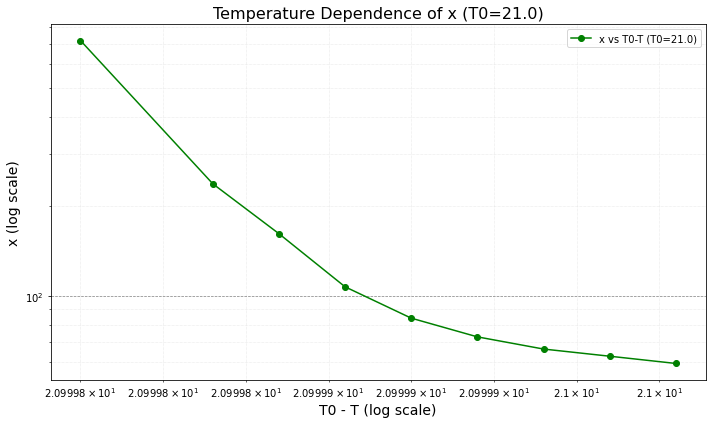

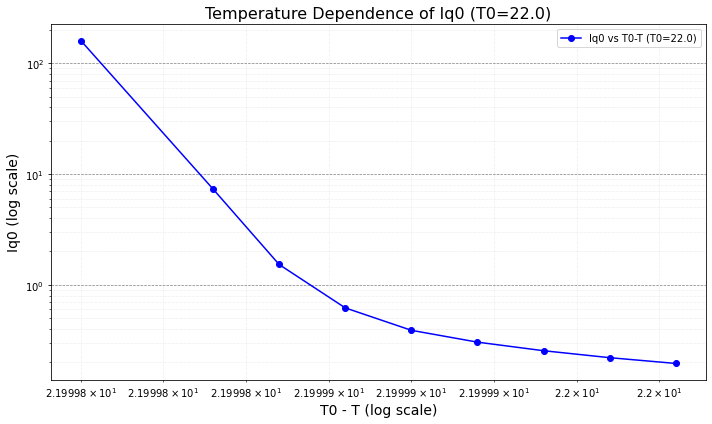

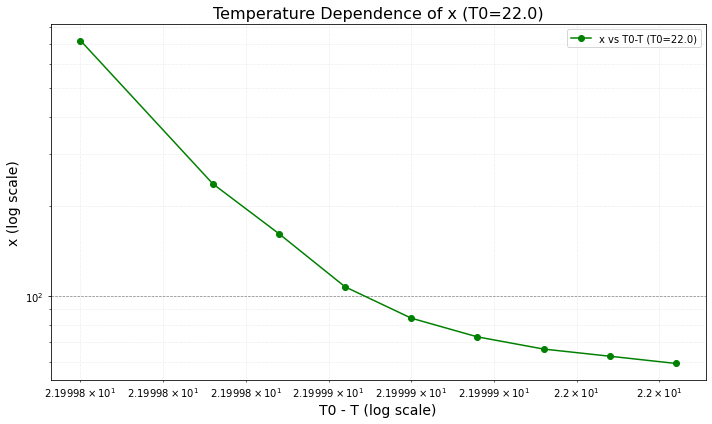

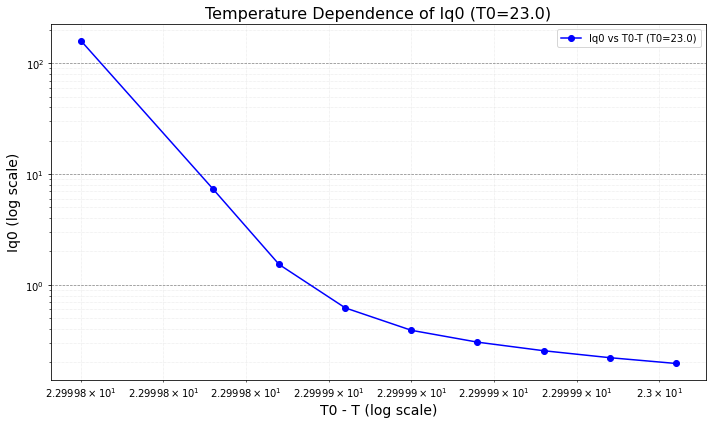

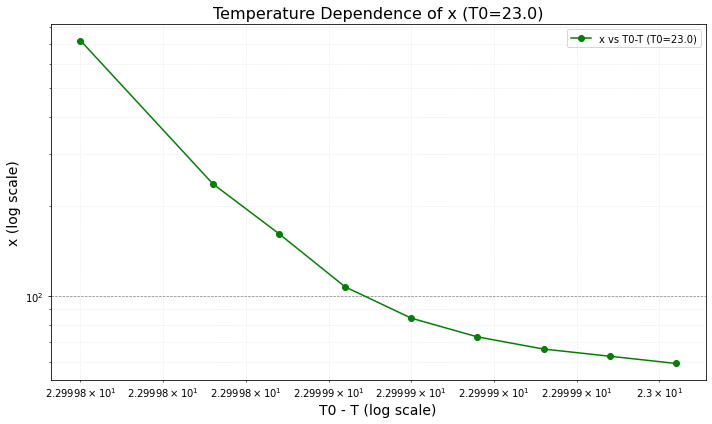

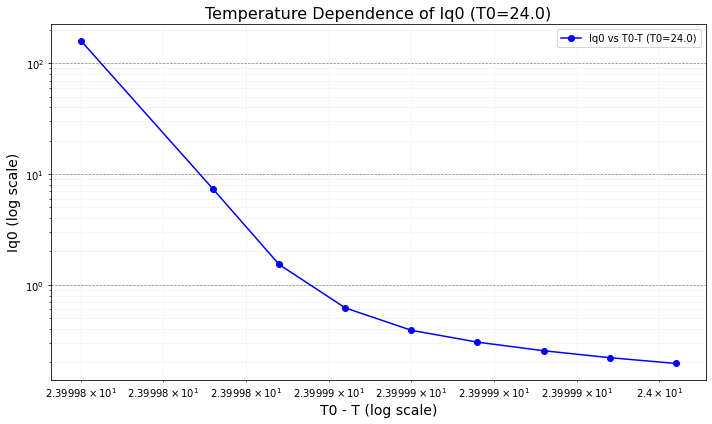

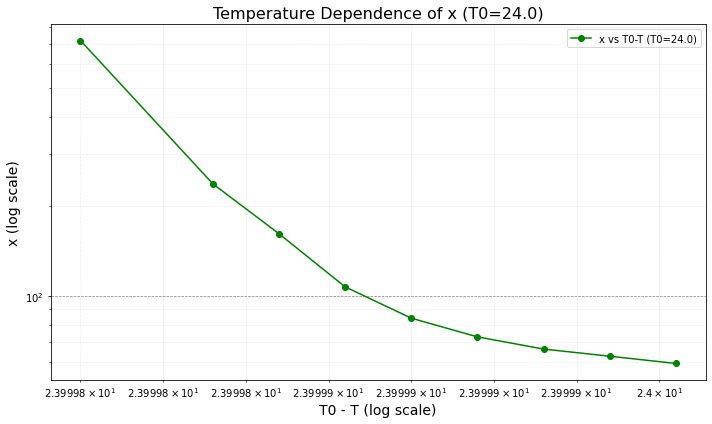

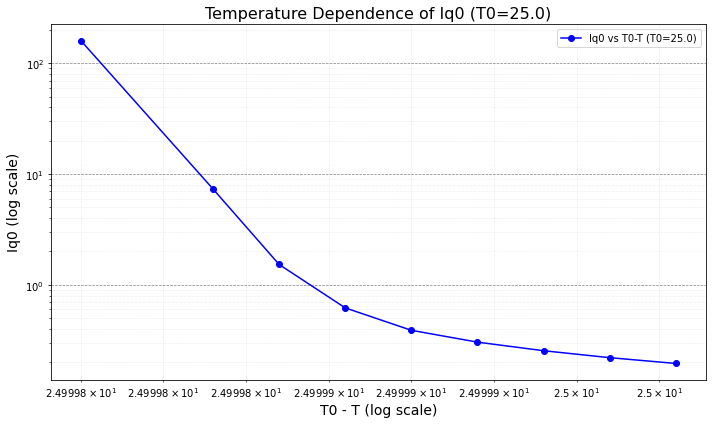

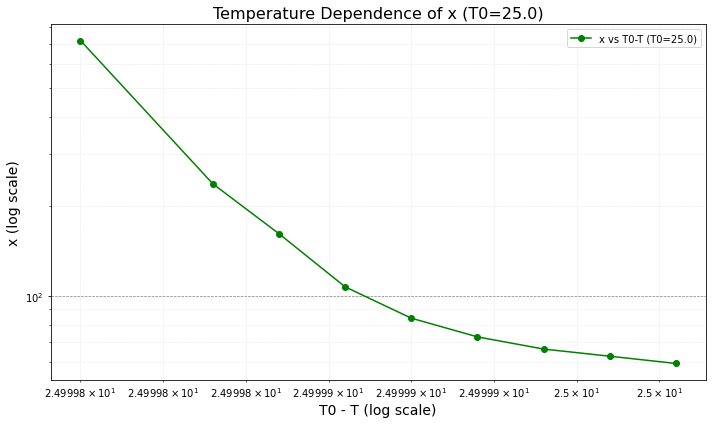

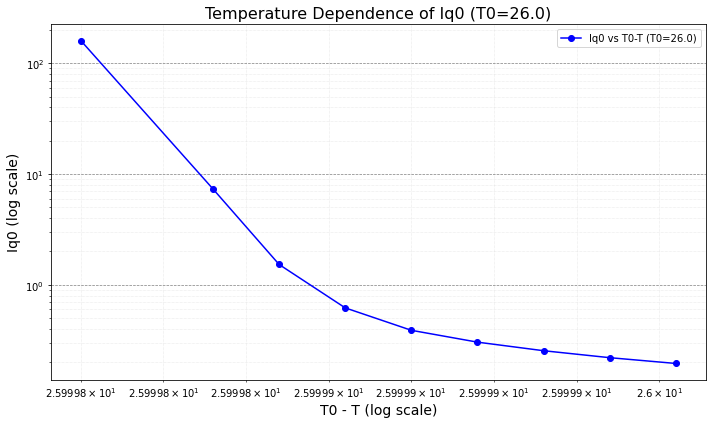

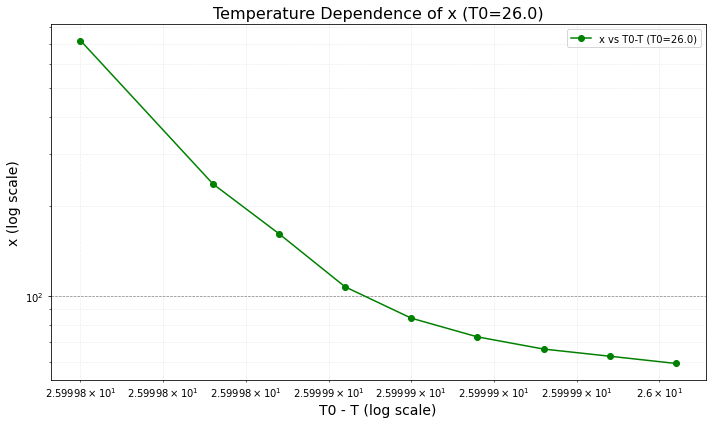

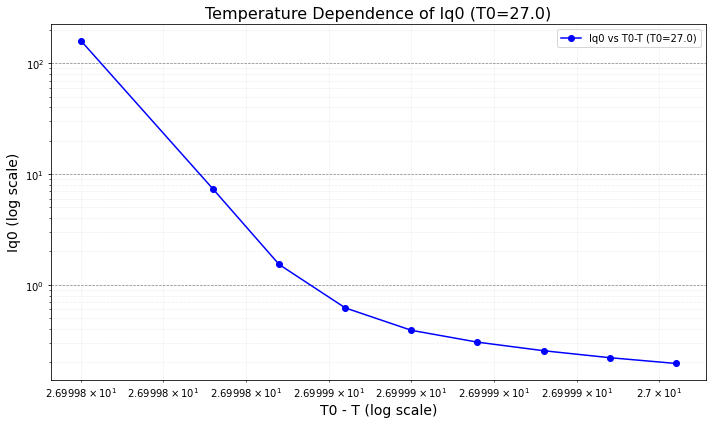

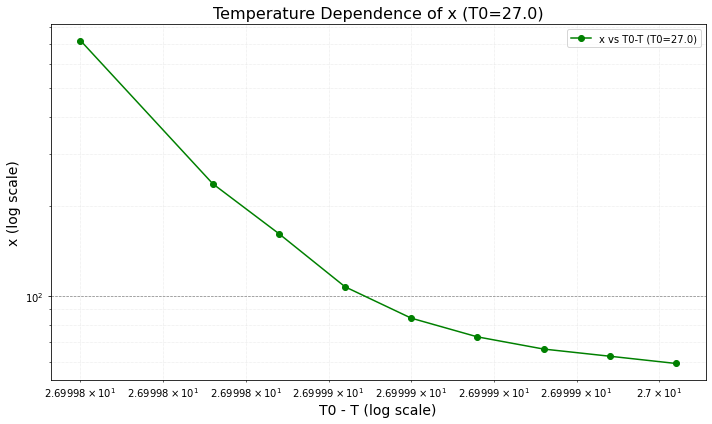

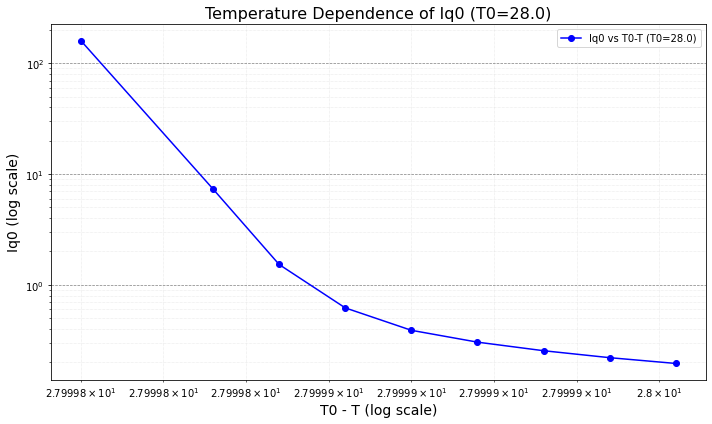

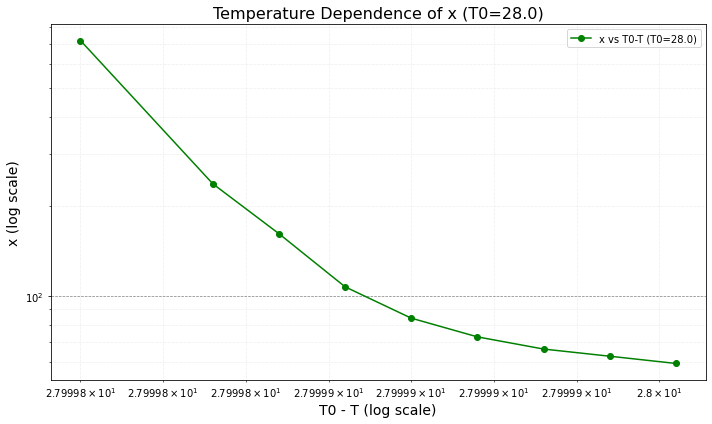

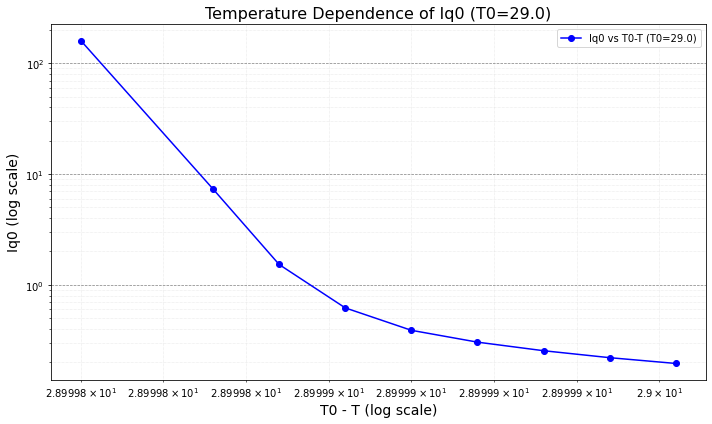

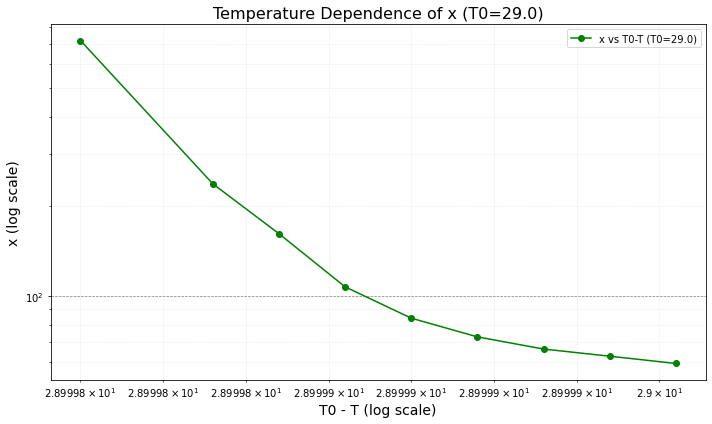

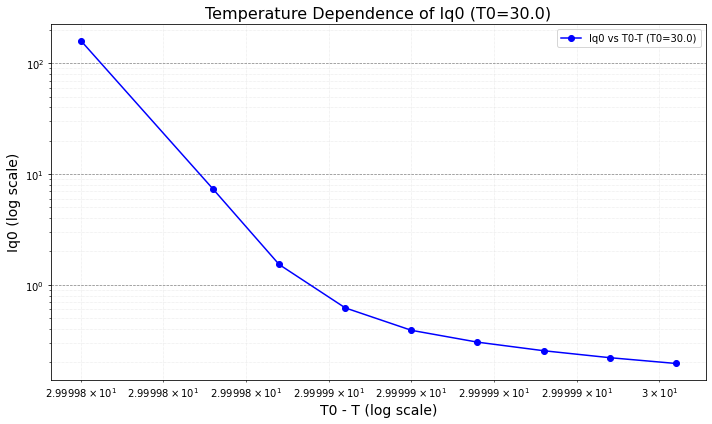

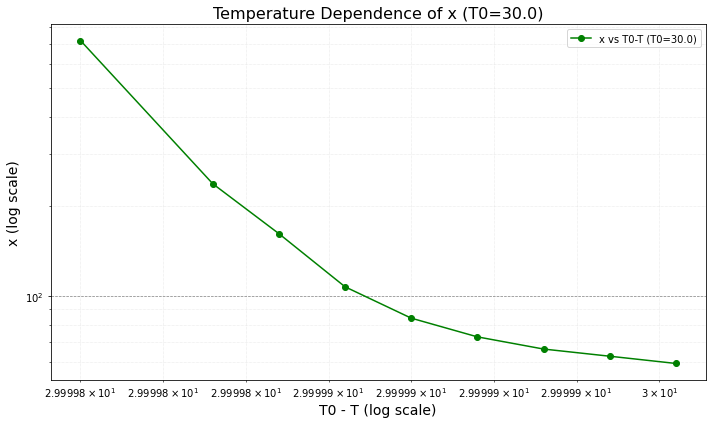

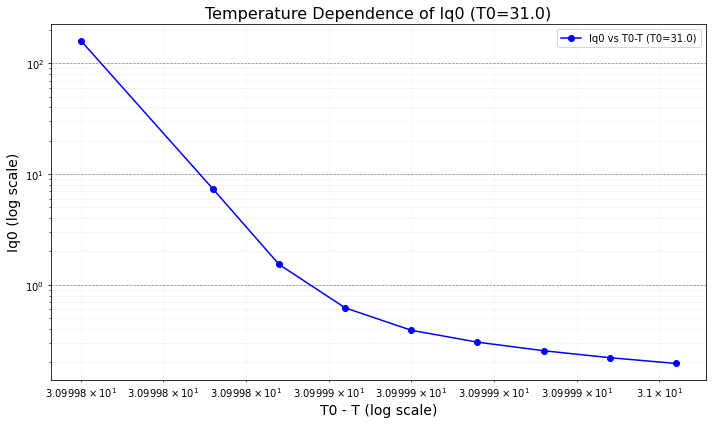

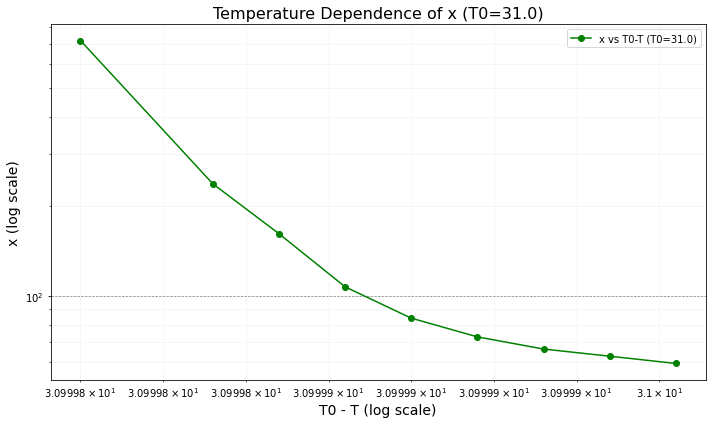

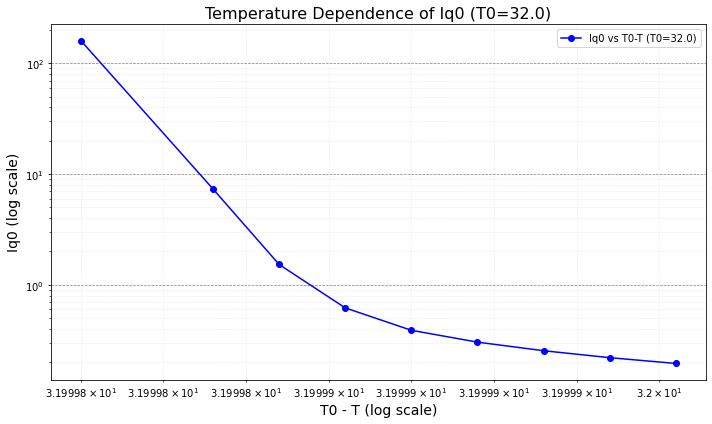

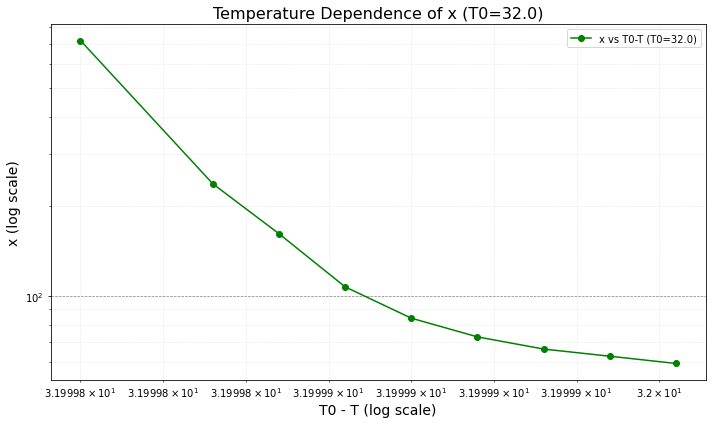

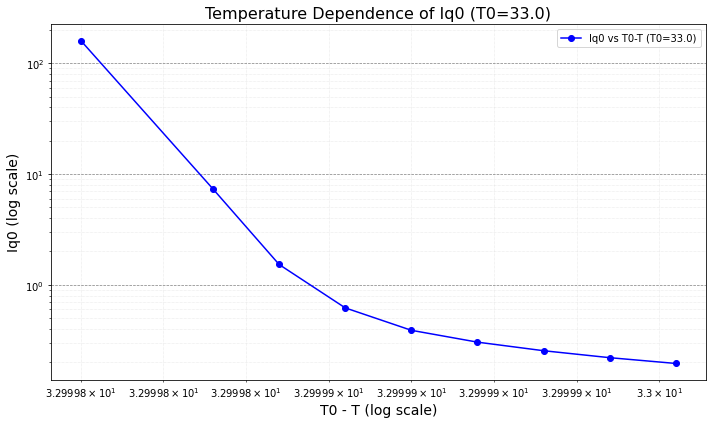

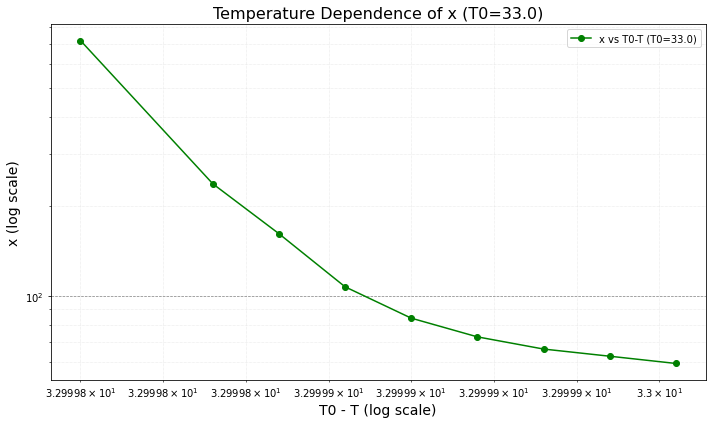

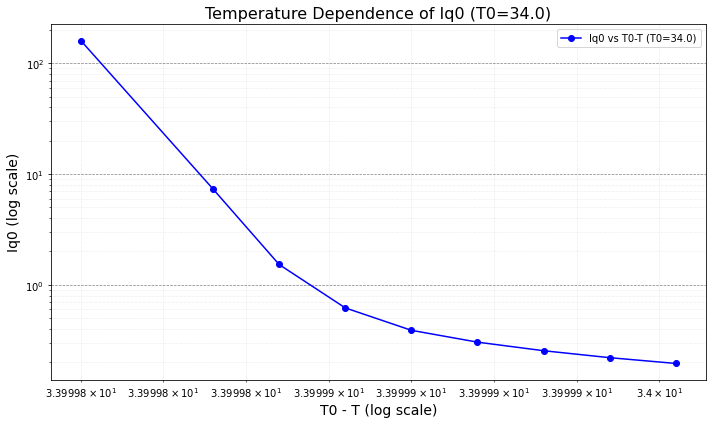

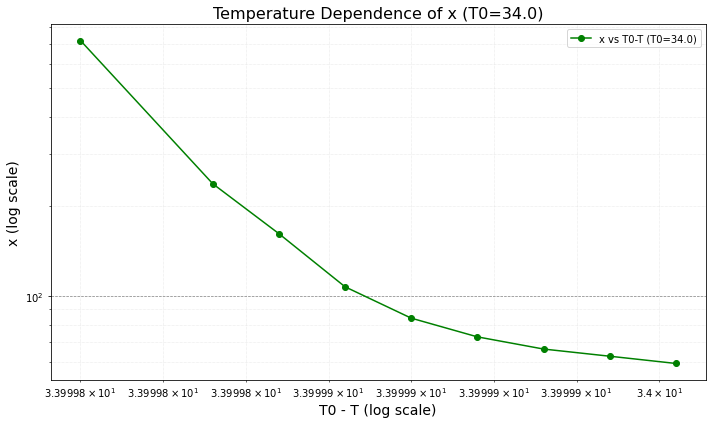

In [60]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from matplotlib.ticker import LogLocator

# Load the data
with open('checkpoint.pickle', 'rb') as f:
    avg_ramp_up = pickle.load(f)
    avg_ramp_down = pickle.load(f)
    t_el = pickle.load(f)
    ql_sta = pickle.load(f)
    ql_dyn = pickle.load(f)

# Function to preprocess data and retain valid indices
def preprocess_data_with_indices(avg_data_list, ql_sta):
    """
    Preprocess the data to remove non-positive values from q and I.
    Returns cleaned q, avg_data_list, and the indices of valid curves.
    """
    cleaned_data_list = []
    cleaned_ql_sta = []
    valid_indices = []  # Track valid curve indices

    for idx, curve in enumerate(avg_data_list[:-1]):  # Exclude the last curve
        q = ql_sta
        i = curve['saxs_1d']
        
        # Filter to ensure both q and I are positive
        valid_indices_curve = (q > 0) & (i > 0)
        cleaned_q = q[valid_indices_curve]
        cleaned_i = i[valid_indices_curve]

        if len(cleaned_q) > 0 and len(cleaned_i) > 0:
            cleaned_ql_sta.append(cleaned_q)
            cleaned_data_list.append({'saxs_1d': cleaned_i})
            valid_indices.append(idx)  # Store index of valid curve

    return cleaned_data_list, cleaned_ql_sta, valid_indices

# Preprocess the data and get valid indices
avg_ramp_up_cleaned, ql_sta_cleaned, valid_indices = preprocess_data_with_indices(avg_ramp_up, ql_sta)

# Map valid indices to temperatures
temperatures = [t_el[i] for i in valid_indices]  # Correctly aligned temperatures
print(f"Temperatures for cleaned curves: {temperatures}")

# Define the fitting function
def scattering_fit(q, Iq0, x):
    b = 1.7815  # Fixed value
    return Iq0 / (1 + (x * q)**b)

# Fit each temperature curve
fitted_parameters = []

for i, (q, data) in enumerate(zip(ql_sta_cleaned, avg_ramp_up_cleaned)):
    I = data['saxs_1d']

    # Fit the curve
    try:
        popt, pcov = curve_fit(scattering_fit, q, I, p0=[np.max(I), 1], bounds=([0, 0], [np.inf, np.inf]))
        Iq0_fit, x_fit = popt
        fitted_parameters.append((Iq0_fit, x_fit))
    except RuntimeError:
        pass

# Ensure temperatures and fitted parameters are aligned
if len(fitted_parameters) != len(temperatures):
    raise ValueError("Mismatch between fitted parameters and temperature list!")

# Explore different T0 values
T0_values = np.linspace(20, 34, 15)  # 15 equally spaced T0 values between 20 and 34

for T0 in T0_values:
    # Compute T0 - T
    T_diff = [T0 - T for T in temperatures]

    # Extract scaling coefficients
    Iq0_values = [param[0] for param in fitted_parameters]
    x_values = [param[1] for param in fitted_parameters]

    # Plot Iq0 vs T0 - T
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.loglog(T_diff, Iq0_values, 'o-', color='blue', label=f'Iq0 vs T0-T (T0={T0:.1f})')
    ax.set_xlabel('T0 - T (log scale)', fontsize=14)
    ax.set_ylabel('Iq0 (log scale)', fontsize=14)
    ax.set_title(f'Temperature Dependence of Iq0 (T0={T0:.1f})', fontsize=16)
    ax.grid(which='major', linestyle='--', linewidth=0.7, color='gray')
    ax.grid(which='minor', linestyle=':', linewidth=0.5, color='lightgray')
    ax.legend()
    plt.tight_layout()
    plt.show()

    # Plot x vs T0 - T
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.loglog(T_diff, x_values, 'o-', color='green', label=f'x vs T0-T (T0={T0:.1f})')
    ax.set_xlabel('T0 - T (log scale)', fontsize=14)
    ax.set_ylabel('x (log scale)', fontsize=14)
    ax.set_title(f'Temperature Dependence of x (T0={T0:.1f})', fontsize=16)
    ax.grid(which='major', linestyle='--', linewidth=0.7, color='gray')
    ax.grid(which='minor', linestyle=':', linewidth=0.5, color='lightgray')
    ax.legend()
    plt.tight_layout()
    plt.show()
